In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from kera.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import pickle


from unet_utils import *
from loss_function import my_iou_metric
import unet_model import unet

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

Using TensorFlow backend.


### Load Data

In [0]:
# Getting the data back
with open(data_path, 'rb') as f:
    sizes_test, test_ids = pickle.load(f)

In [5]:
X_train, Y_train, X_test = load_dataset()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(670, 256, 256, 3)
(670, 256, 256, 1)
(65, 256, 256, 3)


In [6]:
# Split data train-validate
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(603, 256, 256, 3)
(603, 256, 256, 1)
(67, 256, 256, 3)
(67, 256, 256, 1)


### Unet Model

In [8]:
Unet_model = Unet()
Unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

### Compile

In [0]:
# iterations
batchsize = 8
epochs =50

# Compile
Unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
# Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batchsize, shuffle=True)
validation_generator = validation_datagen.flow(X_val, Y_val, batch_size=batchsize, shuffle=True)

# callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

# Fit model
history = Unet_model.fit_generator(train_generator, steps_per_epoch=X_train.shape[0] // batchsize, verbose=2,
                                   validation_data=validation_generator, validation_steps=X_val.shape[0] // batchsize,
                                   callbacks=[earlystopper, checkpointer], epochs=epochs)

### use best model

In [0]:
model = load_model(model_path, 
                   custom_objects={'my_iou_metric': my_iou_metric})


In [12]:
#del preds_val, preds_test
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 0s 7ms/step


### Visualize some images

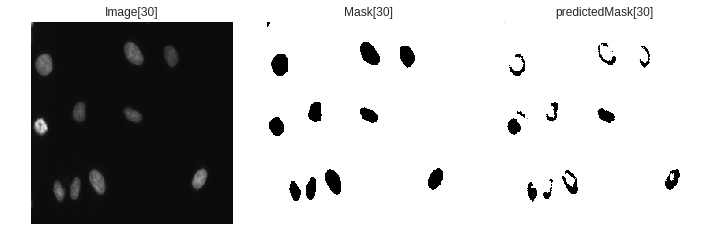

In [13]:
# Perform a sanity check on some random validation samples

ix = 30
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(X_val[ix])
plt.axis('off')
plt.title('Image[{}]'.format(ix))

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_val[ix]))
plt.axis('off')
plt.title('Mask[{}]'.format(ix))

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_val[ix]))
plt.axis('off')
plt.title('predictedMask[{}]'.format(ix))

plt.tight_layout()
plt.show()

### Test images

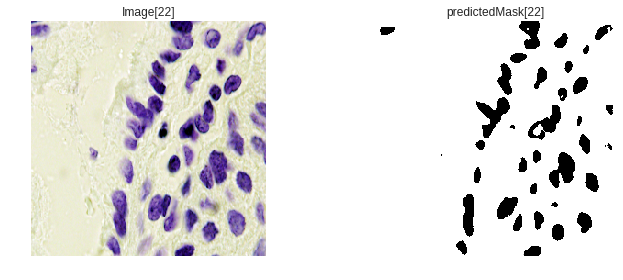

In [14]:
# Perform a sanity check on some random test samples


ix = 22
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(X_test[ix])
plt.axis('off')
plt.title('Image[{}]'.format(ix))


plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds_test[ix]))
plt.axis('off')
plt.title('predictedMask[{}]'.format(ix))

plt.tight_layout()
plt.show()